In [1]:
!python ldc_2d_zeroEq-pic.py

/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
[W224 14:16:44.308496835 init.cpp:767] Warning: nvfuser is no longer supported in torch script, use _jit_set_nvfuser_enabled is deprecated and a no-op (function operator())
[14:16:44] - JitManager: {'_enabled': False, '_arch_mode': <JitArchMode.ONLY_ACTIVATION: 1>, '_use_nvfuser': True, '_autograd_nodes': False}
[14:16:44] - GraphManager: {'_func_arch': False, '_debug': False, '_func_arch_allow_partial_hessian': True}
[14:16:44] - AmpManager: {'_enabled': False, '_mode': <AmpMode.PER_ORDER_SCALER: 0>, '_dtype': torch.float16, '_default_max_scale': 1, '_autocast_activation': False, '_autocast_firstlayer': False, '_special_terms': [], '_custom_max_scales': {}}
/usr/local/lib/python3.10/dist-packages/modu

/tmp/ipykernel_193/761286774.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('/workspace/modulus-sym/examples/ldc/outputs/ldc_2d_zeroEq/flow_network

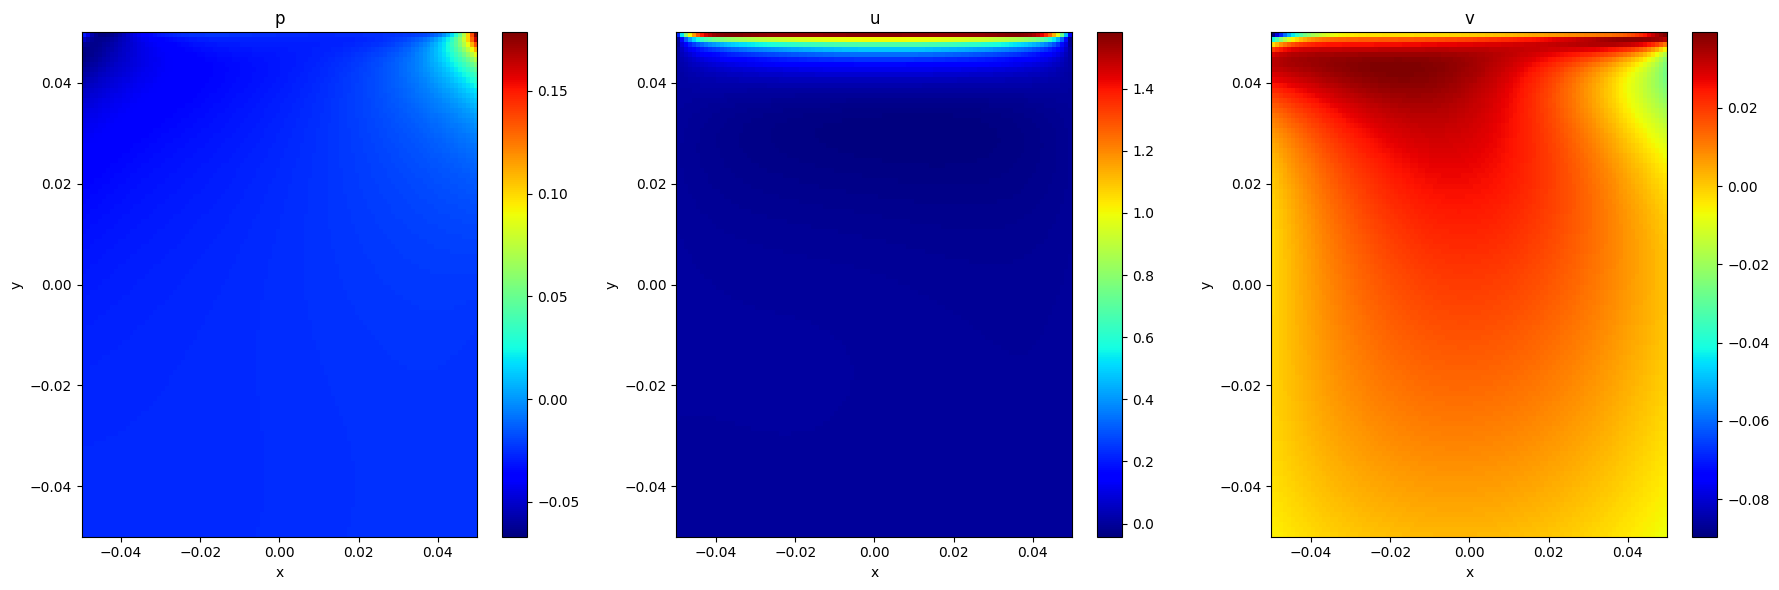

In [2]:
import torch
weights = torch.load('/workspace/modulus-sym/examples/ldc/outputs/ldc_2d_zeroEq/flow_network.0.pth')
# https://stackoverflow.com/a/51812173/8062488 (simiar to this, but not exactly)
# flow_net.load_state_dict(checkpoint['state_dict'])
from modulus.sym.models.fully_connected import FullyConnectedArch
from modulus.sym.models.activation import Activation
from modulus.sym.key import Key

flow_net = FullyConnectedArch(
    # Science & Engineering Knowledge
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u"), Key("v"), Key("p")],
    # Neural Networks Knwoledge (You don't need to know...)
    layer_size=512,
    nr_layers=6,
    skip_connections=False,
    activation_fn=Activation.SILU,
    adaptive_activations=False,
    weight_norm=True
)

flow_net.load_state_dict(weights)
import numpy as np
# Define the domain
x_values = np.linspace(-0.05, 0.05, 100)
y_values = np.linspace(-0.05, 0.05, 100)
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Flatten the grid arrays to create inputs for the model
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Convert to PyTorch tensors
x_tensor = torch.tensor(x_flat, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_flat, dtype=torch.float32).unsqueeze(1)

# Create input dictionary for the model
inputs = {"x": x_tensor, "y": y_tensor}
# Pass inputs through the model to get predictions
output = flow_net(inputs)

u_flat = output["u"].detach().numpy()
v_flat = output["v"].detach().numpy()
p_flat = output["p"].detach().numpy()

# Reshape the outputs back to grid shape
u_grid = u_flat.reshape(x_grid.shape)
v_grid = v_flat.reshape(x_grid.shape)
p_grid = p_flat.reshape(x_grid.shape)


import matplotlib.pyplot as plt
# Plot the color maps
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# Plot p
im0 = axs[0].imshow(p_grid, extent=[-0.05, 0.05, -0.05, 0.05], origin='lower', cmap='jet', aspect='auto')
axs[0].set_title('p')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
fig.colorbar(im0, ax=axs[0])

# Plot u
im1 = axs[1].imshow(u_grid, extent=[-0.05, 0.05, -0.05, 0.05], origin='lower', cmap='jet', aspect='auto')
axs[1].set_title('u')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
fig.colorbar(im1, ax=axs[1])

# Plot v
im2 = axs[2].imshow(v_grid, extent=[-0.05, 0.05, -0.05, 0.05], origin='lower', cmap='jet', aspect='auto')
axs[2].set_title('v')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()